# Swarm Intelligence for Autonomous Microgrid Energy Balancing
## Problem Statement
Modern microgrids integrate renewable energy sources like solar and wind, but their inherently variable output causes frequent mismatches between supply and demand. Traditional centralized control methods are slow to respond, require high communication overhead, and are vulnerable to single-point failures. The challenge is to design a decentralized, adaptive, and scalable approach that can automatically balance energy generation, storage, and consumption in real time — without relying on a central controller.

## Proposed Solution
Use swarm intelligence algorithms (e.g., Particle Swarm Optimization or Ant Colony Optimization) to coordinate distributed energy resources in a microgrid. In this approach:

*   Each node (generator, storage unit, or load) acts as an intelligent agent that shares minimal local information.

*   Agents iteratively update their decisions on energy production, consumption, or storage by following simple rules inspired by swarm behavior (like flocking birds or ants finding food).

*   The system converges to a global balance of energy through self-organization, reducing reliance on centralized control.

## Key Benefits:


*   Real-time adaptability: Quickly responds to changing energy demand or renewable fluctuations.

*   Decentralization: Eliminates single-point failure risks.

*   Scalability: Works as more nodes or resources are added.

*   Efficiency: Optimizes power flow and minimizes losses.









In [ ]:
!pip -q install pyswarms pandas numpy matplotlib


In [ ]:
import pandas as pd

df = pd.read_csv("energy_dataset_.csv")
df.head()


,Type_of_Renewable_Energy,Installed_Capacity_MW,Energy_Production_MWh,Energy_Consumption_MWh,Energy_Storage_Capacity_MWh,Storage_Efficiency_Percentage,Grid_Integration_Level,Initial_Investment_USD,Funding_Sources,Financial_Incentives_USD,GHG_Emission_Reduction_tCO2e,Air_Pollution_Reduction_Index,Jobs_Created
0,4,93.423205,103853.2206,248708.4892,2953.248771,89.887562,4,4.732248e+08,1,9.207772e+06,6663.816572,81.742461,1366
1,4,590.468942,190223.0649,166104.1642,5305.174042,84.403343,4,1.670697e+08,2,1.685101e+06,30656.049820,78.139042,1743
2,1,625.951142,266023.4824,424114.6308,2620.192622,60.498249,2,8.463610e+07,2,5.111813e+06,1749.613759,8.461296,363
3,1,779.998728,487039.5296,308337.7316,1925.250307,86.897861,3,3.967690e+08,2,4.805902e+06,43233.237820,8.402441,2821
4,3,242.106837,482815.0856,360437.7705,3948.945383,70.949351,2,3.574413e+07,1,1.668601e+07,14858.662760,28.822867,2583


In [ ]:
import numpy as np

needed = [
    'Energy_Production_MWh',
    'Energy_Consumption_MWh',
    'Energy_Storage_Capacity_MWh',
    'Storage_Efficiency_Percentage'
]
missing = [c for c in needed if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

df = df.copy()
df['eff'] = df['Storage_Efficiency_Percentage'] / 100.0

np.random.seed(42)
sample_n = 200
idx = np.random.choice(len(df), size=sample_n, replace=False)
d = df.iloc[idx].reset_index(drop=True)

gen = d['Energy_Production_MWh'].to_numpy()
load = d['Energy_Consumption_MWh'].to_numpy()
cap  = d['Energy_Storage_Capacity_MWh'].to_numpy()
eff  = d['eff'].to_numpy()

baseline_mismatch = np.abs(gen - load).sum()
print("Nodes:", len(d))
print("Baseline total mismatch (MWh):", baseline_mismatch)


Nodes: 200
Baseline total mismatch (MWh): 33523034.089983


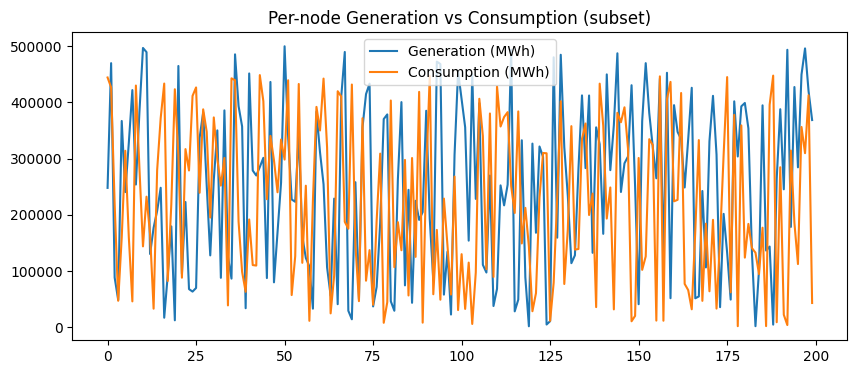

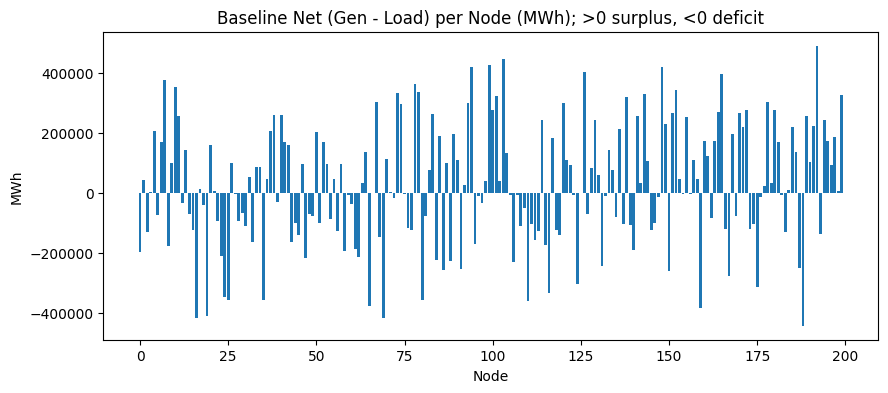

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(gen, label='Generation (MWh)')
plt.plot(load, label='Consumption (MWh)')
plt.title('Per-node Generation vs Consumption (subset)')
plt.legend()
plt.show()

net = gen - load
plt.figure(figsize=(10,4))
plt.bar(range(len(net)), net)
plt.title('Baseline Net (Gen - Load) per Node (MWh); >0 surplus, <0 deficit')
plt.xlabel('Node')
plt.ylabel('MWh')
plt.show()


In [ ]:
def objective_single(x):
    x = np.clip(x, 0, cap)
    net_after = gen - load - x
    mismatch = np.abs(net_after).sum()
    stored_reward = (x * eff).sum()
    return mismatch - 0.01 * stored_reward

def objective_swarm(X):
    return np.array([objective_single(x) for x in X])


In [ ]:
import pyswarms as ps
dims = len(d)
lb = np.zeros(dims)
ub = cap.copy()
bounds = (lb, ub)

options = {'c1': 0.6, 'c2': 0.9, 'w': 0.7}
optimizer = ps.single.GlobalBestPSO(
    n_particles=30, dimensions=dims, options=options, bounds=bounds
)
best_cost, best_pos = optimizer.optimize(objective_swarm, iters=60)


2025-09-07 02:26:32,050 - pyswarms.single.global_best - INFO - Optimize for 60 iters with {'c1': 0.6, 'c2': 0.9, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|60/60, best_cost=3.34e+7
2025-09-07 02:26:32,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33388528.65977254, best pos: [2251.83462221 3192.61488838  153.43012261 1529.44196739 2309.7393933
  388.89539438 1047.14255603 5076.51156214  324.86826159 5139.93384168
 1654.3667004   327.39192393  276.95779639  636.67622212  965.5558294
  198.84718433  559.11024988 1079.19481343  523.93962034 4149.80298089
  543.16757319 3992.88396881 1336.14736047 2717.03587176  821.51490198
 2482.03253629 5204.63442295  353.95848553 2647.68800068 1632.01819271
 5882.21174674 1558.63496463 1677.04866049 3235.41892656 2562.53583544
 2859.88806946   61.63836858 7065.35263666 2470.15758866 3117.74216973
   61.8166419  2868.53982305 5625.21762336  519.33123975  512.24255662
  513.36000121 1128.13859074 3276.33665396 